#### How does the bond price change with non-zero default probability for the issuer ?

For simplicity consider a zero coupon bond, with a flat probability of default $p_{\text{def}}$ and a recovery rate $R$.
The price of the bond will be

$$\begin{equation}
\begin{cases}
D_f\cdot R \cdot N\quad\text{ with default} \\
D_f\cdot N\quad \text{ with no default}
\end{cases}
\end{equation}
$$

But we know the probability of default so the price estimate will be

$$ \mathbb{E}(\textbf{ZCB}) = p_{\text{def}}\cdot(D_f\cdot R\cdot N) + (1 - p_{\text{def}})(D_f\cdot N)$$

This formula can be easily extended to coupon bearing bonds.


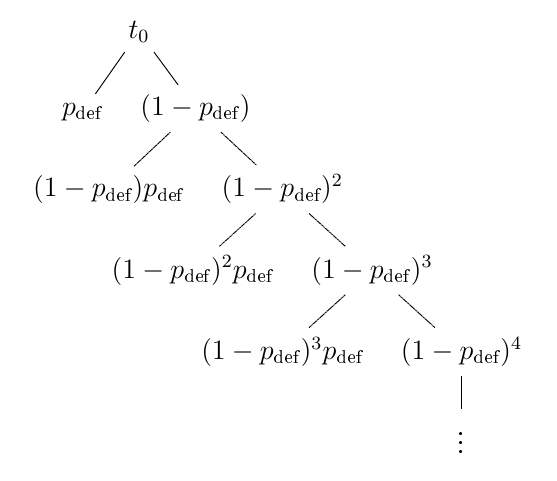

In [1]:
import numpy as np

from dateutil.relativedelta import relativedelta

def TimeInterval(interval):
    tag = interval[-1].lower()
    value = int(interval[:-1])
    if tag == "d":
        return relativedelta(days=value)
    elif tag == "m":
        return relativedelta(months=value)
    elif tag == "y":
        return relativedelta(years=value)
    else:
        raise ValueError(f"Unable to convert {interval}, probably wrong units.")
    
def generate_dates(start_date, end_date, frequency="1y"):
    if isinstance(end_date, str):
        end_date = start_date + TimeInterval(end_date)
    d = start_date
    dates = [start_date]
    while True:
        d += TimeInterval(frequency)
        if d < end_date:
            dates.append(d)
        else:
            dates.append(end_date)
            break
    return dates

class DiscountCurve:
  def __init__(self, pillar_dates, discount_factors):
    self.discount_factors = np.array(discount_factors)
    self.pillar_dates = pillar_dates

  def df(self, adate):
    pillars = [p.toordinal() for p in self.pillar_dates]
    return np.interp(adate.toordinal(), pillars, self.discount_factors)

In [2]:
class FixedRateBond:
    def __init__(self, start_date, K, maturity, tenor, N=100):
        self.start_date = start_date
        self.maturity = maturity
        self.payment_dates = generate_dates(start_date, maturity, tenor)
        self.N = N
        self.K = K
        self.tenor = tenor

    def npv_default(self, dc, pd, R=0.4):
        val = 0
        for i in range(1, len(self.payment_dates)):
            tau = (self.payment_dates[i] - self.payment_dates[i-1]).days/365
            pd_t = pd*tau
            cpn = self.N*self.K*tau
            if i == len(self.payment_dates)-1:
                cpn += self.N
            val += (pd_t*(1-pd_t)**(i-1)*R*self.N + (1-pd_t)**i*cpn)*dc.df(self.payment_dates[i])
        return val

    def npv(self, dc):
        val = 0
        for i in range(1, len(self.payment_dates)):
            tau = (self.payment_dates[i] - self.payment_dates[i-1]).days/365
            val += self.K*tau*dc.df(self.payment_dates[i])
        val += dc.df(self.payment_dates[-1])
        return self.N*val

Consider a 2Y risky bond paying quarterly coupons. The bond issuer has a default probability of 3% during the next year.
The interest rate term structure is considered flat at 0.05.
  * if the bond buyer enters into an asset swap, determine its spread;
  * check that a CDS with same maturity as the asset swap has similar spread;
  * finally check how the asset swap spread changes as a function of the probability of default.

In [4]:
from datetime import date
from dateutil.relativedelta import relativedelta

today = date.today()
dfs = [1/(1+0.05)**i for i in range(6)]
dates = [today+relativedelta(years=i) for i in range(len(dfs))]
dc = DiscountCurve(dates, dfs)

In [5]:
bond = FixedRateBond(today, 0.03, "2y", "3m", 100)

print (f"Bond price: {bond.npv(dc):.3f}")

Bond price: 96.386


In [6]:
market_price_bond = bond.npv_default(dc, pd=0.05, R=0.4)
print (f"Bond price: {market_price_bond:.2f}")

Bond price: 91.14


In [7]:
class ParAssetSwap:
    def __init__(self, bond):
        self.bond = bond
        self.fixed_dates = bond.payment_dates

    def asspread(self, dc, pd):
        bond_mkt_price = self.bond.npv_default(dc, pd)
        A = self.annuity(dc)
        s = (self.bond.npv(dc)-bond_mkt_price)/(A*self.bond.N)
        return s

    def annuity(self, dc):
        a = 0
        for i in range(1, len(self.fixed_dates)):
            tau = (self.fixed_dates[i]-self.fixed_dates[i-1]).days / 365
            a += dc.df(self.fixed_dates[i])*tau
        return a

In [8]:
asw = ParAssetSwap(bond)
print (f"ASW spread: {asw.asspread(dc, 0.05):.3f}")

ASW spread: 0.028


### Credit Default Swap

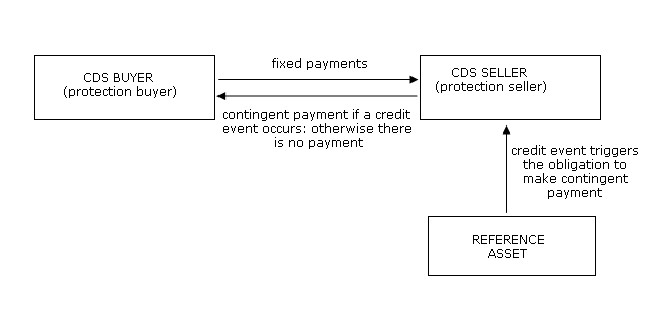

$$NPV_{CDS} = NPV_{\text{default}} - NPV_{\text{premium}}(s) = 0$$

$$NPV_{\text{default}} = NPV_{\text{premium}}(s)$$

$$s = \cfrac{NPV_{\text{default}}}{NPV_{\text{premium}}}$$



In [11]:
class CreditDefaultSwap:
    def __init__(self, nominal, start_date, maturity, tenor="3m", recovery=0.4):
        self.N = nominal
        self.payment_dates = generate_dates(start_date, maturity, tenor)
        self.recovery = recovery

    def npv_premium_leg(self, dc, pd):
        npv = 0
        for i in range(1, len(self.payment_dates)):
            tau = (self.payment_dates[i] - self.payment_dates[i-1]).days/365
            pd_t = pd*tau
            npv += dc.df(self.payment_dates[i])*tau*(1-pd_t)**i
        return npv*self.N

    def npv_default_leg(self, dc, pd):
        npv = 0
        for i in range(1, len(self.payment_dates)):
            tau = (self.payment_dates[i] - self.payment_dates[i-1]).days/365
            pd_t = pd*tau
            npv += dc.df(self.payment_dates[i])*(1-pd_t)**(i-1)*pd_t
        return npv*self.N*(1-self.recovery)

    def spread(self, dc, pd):
        num = self.npv_default_leg(dc, pd)
        den = self.npv_premium_leg(dc, pd)
        return num/den

In [12]:
cds = CreditDefaultSwap(1, today, "2y", "3m")
print (f"CDS spread: {cds.spread(dc, 0.05):.3f}")

CDS spread: 0.030


In [13]:
import numpy as np

pds = np.arange(0, 1.0, 0.01)

bond = FixedRateBond(today, 0.03, "5y", "1y", 100)
asw = ParAssetSwap(bond)

spreads = []
prices = []
for pd in pds:
  market_price_bond = bond.npv_default(dc, pd=pd, R=0.4)
  prices.append(market_price_bond)
  spreads.append(asw.asspread(dc, pd))

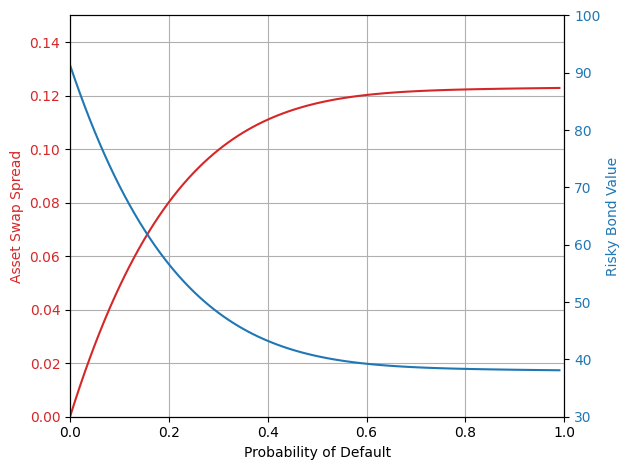

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Probability of Default')
ax1.set_ylabel('Asset Swap Spread', color=color)
ax1.plot(pds, spreads, color=color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.15)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Risky Bond Value', color=color)
ax2.plot(pds, prices, color=color)
ax2.set_ylim(30, 100)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()